In [2]:
#Run this cell twice to ensure all libraries are imported
from ROOT import *
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import numpy as np
import deepdish.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import keras
from keras.models import Sequential, load_model
from sklearn.externals import joblib
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import ks_2samp

### GPU Settings

In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

2018-12-01 21:40:29.943504: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-12-01 21:40:30.171172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
totalMemory: 11.90GiB freeMemory: 10.70GiB
2018-12-01 21:40:30.171203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-12-01 21:40:30.434933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-12-01 21:40:30.434970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-12-01 21:40:30.434976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-12-01 21:40:30.435223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replic

# 1. Data Import And Processing

*ttHbb_PowhegPythia.root:* ttHbb Data

*TTLJ_PowhegPythia_ttbb.root:* ttbb Data

In [3]:
data = TFile.Open("/home/minerva1993/public/v808/nosplit/ttHbb_PowhegPythia.root")
data2 = TFile.Open("/home/minerva1993/public/v808/nosplit/TTLJ_PowhegPythia_ttbb.root")
tree = data.Get("ttbbLepJets/tree")
tree2 = data2.Get("ttbbLepJets/tree")

### 1.1 Transfer ROOT File to CSV

In [5]:
def tree_to_df(tree, branch_names=[], index_name='', drop_roofit_labels=False):
    if tree is None:
        return None

    branch_list = tree.GetListOfBranches()
    all_branch_names = [branch_list.At(i).GetName() for i in range(branch_list.GetEntries())]
    if len(branch_names) == 0:
        branch_names = all_branch_names
    for bn in branch_names[:]:
        if bn not in all_branch_names:
            branch_names.remove(bn)
        if drop_roofit_labels:
            if bn.endswith('_lbl'):
                branch_names.remove(bn)

    arrs = tree2array(tree, branch_names, start = 0, stop = 40000)
    #Stop at 40000 data points
    df = pd.DataFrame(arrs)

    if len(index_name) == 0:
        for col in df.columns:
            if col.startswith('__index__'):
                index_name = col
                break
    if len(index_name):
        try:
            df[index_name] = df[index_name].astype(np.int32)
            df.set_index(index_name, inplace=True)
        except BaseException:
            pass

    if drop_roofit_labels:
        df.columns = [col.replace('_idx', '') for col in df.columns]

    n_tree = tree.GetEntries()
    n_df = len(df.index)

    return df 

In [6]:
dftree = tree_to_df(tree)
#dftree - ttHbb
dftree_bg = tree_to_df(tree2)
#dftree_bg - TTLJ

### 1.2 Import Trained Model Weights

> *jet_selection.h5*: The neural network model for Higgs pair selection

> *jet_randomforest.h5*: The random forest model for Higgs pair selection

> *scaler.save*: Standard scaler used for prediction data

In [8]:
jet_selection = joblib.load('jet_selection.h5')
jet_scaler = joblib.load('scaler.save')
jet_rf = joblib.load('jet_randomforest.h5')

### 1.3 Data Pre-processing

In [10]:
#Select the proper Higgs pair from jet
def select_jet(df):
    
    columns = ['draddjets','lepton_pT','lepton_eta','lepton_E','MET','MET_phi','jet_number','event_weight','delta_phi','delta_eta','delta_R','invmass','lepton_delta_R_1','lepton_delta_eta_1','H']
    
    for t in range(1,3):
        for i in ['jet_pT','jet_eta','jet_E','jet_CvsB']:
            columns.append(i+'_'+str(t))
    
    overall = []
    available_jets = []

    #append all the invariant columns
    invariants = []

    for t in ['draddjets','lepton_pT','lepton_eta','lepton_E','MET','MET_phi','jet_number']:
        invariants.append(df[t][0])

    product = df['lepton_SF'][0][0] * df['jet_SF_CSV_30'][0][0] * df['PUWeight'][0][0] * df['genweight'][0]
    invariants.append(product)

    #Loop over possible combinations
    for t in range(len(df['jet_pT'][0]) - 1):
        for m in range(t+1, len(df['jet_pT'][0])):

            #initialize variant data column
            variants = []

            #set the jet pair
            jet_pair = (t, m)

            #Delta_phi, delta_eta and delta_R
            x = df['jet_phi'][0][jet_pair[0]] - df['jet_phi'][0][jet_pair[1]]
            delta_phi = process_delta_phi(x)
            delta_eta = df['jet_eta'][0][jet_pair[0]] - df['jet_eta'][0][jet_pair[1]]
            delta_R = math.sqrt(delta_phi**2 + delta_eta**2)

            #invmass
            pt1, pt2 = math.fabs(df['jet_pT'][0][jet_pair[0]]), math.fabs(df['jet_pT'][0][jet_pair[1]])
            pX1, pX2 = pt1 * math.cos(df['jet_phi'][0][jet_pair[0]]), pt2 * math.cos(df['jet_phi'][0][jet_pair[1]])
            pY1, pY2 = pt1 * math.sin(df['jet_phi'][0][jet_pair[0]]), pt2 * math.sin(df['jet_phi'][0][jet_pair[1]])
            pZ1, pZ2 = pt1 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][0][jet_pair[0]]))), pt2 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][0][jet_pair[1]])))
            invmass = math.sqrt((df['jet_E'][0][jet_pair[0]] + df['jet_E'][0][jet_pair[1]])**2 - (pX1 + pX2)**2 - (pY1 + pY2)**2 - (pZ1 + pZ2)**2)

            #H
            H = df['jet_pT'][0][jet_pair[0]] + df['jet_pT'][0][jet_pair[1]] + df['lepton_pT'][0]

            #delta_lepton_R
            y_1 = df['jet_phi'][0][jet_pair[0]] - df['lepton_phi'][0]
            delta_phi_lep_1 = process_delta_phi(y_1)
            delta_eta_lep_1 = df['jet_eta'][0][jet_pair[0]] - df['lepton_eta'][0]
            delta_R_lep_1 = math.sqrt(delta_phi_lep_1**2 + delta_eta_lep_1**2)
            
            y_2 = df['jet_phi'][0][jet_pair[1]] - df['lepton_phi'][0]
            delta_phi_lep_2 = process_delta_phi(y_2)
            delta_eta_lep_2 = df['jet_eta'][0][jet_pair[1]] - df['lepton_eta'][0]
            delta_R_lep_2 = math.sqrt(delta_phi_lep_2**2 + delta_eta_lep_2**2)

            variants += [delta_phi, delta_eta, delta_R, invmass, delta_R_lep_1, delta_eta_lep_1, delta_R_lep_2, delta_eta_lep_2, H]
            
            for n in [t, m]:
                for k in ['jet_pT','jet_eta','jet_E','jet_CvsB']:
                    variants += [df[k][0][n]]

            overall.append(invariants + variants)
            available_jets.append((t,m))
    
    #scale data
    overall = jet_scaler.transform(overall)
    #get prediction from both neural networks and random forest
    prediction = jet_selection.predict(overall)
    prediction_rf = jet_rf.predict(overall)
    #The final prediction is made with combined result from NN (80%) and random forest (20%)
    result = [prediction[k][1] * (1 + 0.2 * prediction_rf[k]) for k in range(len(prediction))]
    
    return available_jets[result.index(max(result))]

In [1]:
#Calculate delta phi
def process_delta_phi(x):
    if x > math.pi:
        delta_phi = x - 2*math.pi
    elif x < -math.pi:
        delta_phi = x + 2*math.pi
    else:
        delta_phi = x
    return delta_phi

#Process entire dataset
def process(df):
    columns = ['draddjets','lepton_eta','MET_phi','delta_phi','delta_eta','delta_R','invmass','lepton_delta_R_1','lepton_delta_eta_1','lepton_delta_R_2','lepton_delta_eta_2','H']
    
    for t in range(1,5):
        for i in ['jet_pT','jet_eta','jet_E','jet_CvsB']:
            columns.append(i+'_'+str(t))
    
    end = []
    
    for i in range(df.shape[0]):
        if df['jet_number'][i] >= 6 and df['jet_CSV'][i][2] > 0.8:
            #Check whether the event has over 6 b-jets
            checked = 0
            for m in range(df['jet_number'][i]):
                if df['jet_pT'][i][m] > 20 and np.abs(df['jet_eta'][i][m]) < 2.4:
                    checked += 1
            if checked < 6:
                continue

            parts = []
            for t in ['draddjets','lepton_eta','MET_phi']:
                parts.append(df[t][i])
            
            #Select the jet pair that is the most likely to be the Higgs
            jet_pair = select_jet(df[i:i+1].reset_index())
            
            #Delta_phi, Delta_eta, Delta_R
            x = df['jet_phi'][i][jet_pair[0]] - df['jet_phi'][i][jet_pair[1]]
            delta_phi = process_delta_phi(x)
            delta_eta = df['jet_eta'][i][jet_pair[0]] - df['jet_eta'][i][jet_pair[1]]
            delta_R = math.sqrt(delta_phi**2 + delta_eta**2)
            
            #invmass
            pt1, pt2 = math.fabs(df['jet_pT'][i][jet_pair[0]]), math.fabs(df['jet_pT'][i][jet_pair[1]])
            pX1, pX2 = pt1 * math.cos(df['jet_phi'][i][jet_pair[0]]), pt2 * math.cos(df['jet_phi'][i][jet_pair[1]])
            pY1, pY2 = pt1 * math.sin(df['jet_phi'][i][jet_pair[0]]), pt2 * math.sin(df['jet_phi'][i][jet_pair[1]])
            pZ1, pZ2 = pt1 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][i][jet_pair[0]]))), pt2 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][i][jet_pair[1]])))
            invmass = math.sqrt((df['jet_E'][i][jet_pair[0]] + df['jet_E'][i][jet_pair[1]])**2 - (pX1 + pX2)**2 - (pY1 + pY2)**2 - (pZ1 + pZ2)**2)
            
            #H
            H = df['jet_pT'][i][jet_pair[0]] + df['jet_pT'][i][jet_pair[1]] + df['lepton_pT'][i]
            
            #delta R between lepton and the first particle in the jet pair
            y_1 = df['jet_phi'][i][jet_pair[0]] - df['lepton_phi'][i]
            delta_phi_lep_1 = process_delta_phi(y_1)
            delta_eta_lep_1 = df['jet_eta'][i][jet_pair[0]] - df['lepton_eta'][i]
            delta_R_lep_1 = math.sqrt(delta_phi_lep_1**2 + delta_eta_lep_1**2)
            
            #delta R between lepton and the second particle in the jet pair
            y_2 = df['jet_phi'][i][jet_pair[1]] - df['lepton_phi'][i]
            delta_phi_lep_2 = process_delta_phi(y_2)
            delta_eta_lep_2 = df['jet_eta'][i][jet_pair[1]] - df['lepton_eta'][i]
            delta_R_lep_2 = math.sqrt(delta_phi_lep_2**2 + delta_eta_lep_2**2)
            
            #Combine all together
            parts += [delta_phi, delta_eta, delta_R, invmass, delta_R_lep_1, delta_eta_lep_1, delta_R_lep_2, delta_eta_lep_2, H]
            
            for t in range(len(df['jet_pT'][i])):
                passed = True
                partial = []
                for k in ['jet_pT','jet_eta','jet_E','jet_CvsB']:
                    if k == 'jet_pT':
                        if df[k][i][t] < 30:
                            passed = False
                            break
                    elif k == 'jet_eta':
                        if df[k][i][t] > 2.4 or df[k][i][t] < -2.4:
                            passed = False
                            break
                    partial.append(df[k][i][t])
                
                if passed:
                    parts += partial
                    
                if len(parts) == len(columns):
                    break
                    
            end.append(parts)
            
    print "Column Length: ", len(end[0])
    print "Fixed Length: ", len(columns)
    train_tree = pd.DataFrame(end, columns=columns)
    return train_tree

_The following commented code is for testing the accuracy of the jet selection model. Feel free to uncommented to see the accuracy_

In [11]:
# def calculate_delta_R(phi_1, phi_2, eta_1, eta_2):
#     x = phi_1 - phi_2
#     delta_phi = process_delta_phi(x)
#     delta_eta = eta_1 - eta_2
#     return math.sqrt(delta_phi**2 + delta_eta**2)

# overall = [[],[],[]]

# for i in range(len(dftree_bg['lepton_SF'])):
#     if dftree_bg['jet_number'][i] >= 6 and dftree_bg['jet_CSV'][i][2] > 0.8:
#         checked = 0
#         for m in range(dftree_bg['jet_number'][i]):
#             if dftree_bg['jet_pT'][i][m] > 20 and np.abs(dftree_bg['jet_eta'][i][m]) < 2.4:
#                 checked += 1
#         if checked < 6:
#             continue

#         sets = select_jet(dftree_bg[i:i+1].reset_index())
#         for ind in range(len(sets)):
#             t = sets[ind]
#             phi_1, phi_2 = dftree_bg['jet_phi'][i][t[0]], dftree_bg['jet_phi'][i][t[1]]
#             mt_phi_1, mt_phi_2 = dftree_bg['addbjet1_phi'][i], dftree_bg['addbjet2_phi'][i]
#             eta_1, eta_2 = dftree_bg['jet_eta'][i][t[0]], dftree_bg['jet_eta'][i][t[1]]
#             mt_eta_1, mt_eta_2 = dftree_bg['addbjet1_eta'][i], dftree_bg['addbjet2_eta'][i]

#             dR_11 = calculate_delta_R(phi_1, mt_phi_1, eta_1, mt_eta_1)
#             dR_12 = calculate_delta_R(phi_1, mt_phi_2, eta_1, mt_eta_2)
#             dR_21 = calculate_delta_R(phi_2, mt_phi_1, eta_2, mt_eta_1)
#             dR_22 = calculate_delta_R(phi_2, mt_phi_2, eta_2, mt_eta_2)
            
#             overall[ind].append((dR_11 < 0.4 or dR_12 < 0.4) and (dR_21 < 0.4 or dR_22 < 0.4))

In [12]:
# nmatched = [0,0,0]
# for t in range(len(overall)):
#     for m in overall[t]:
#         if m:
#             nmatched[t] += 1
# print(float(nmatched[0])/len(overall[0]))
# print(float(nmatched[1])/len(overall[0]))
# print(float(nmatched[2])/len(overall[0]))

In [15]:
train_tree = process(dftree)

Column Length:  28
Fixed Length:  28


In [16]:
train_tree_2 = process(dftree_bg)

Column Length:  28
Fixed Length:  28


In [17]:
#train_tree carries the signal data, which are all labeled 1
train_tree['result'] = [1 for i in range(len(train_tree))]

In [18]:
#train_tree_2 carries the background data, which are all labeled 0
train_tree_2['result'] = np.zeros(len(train_tree_2))

In [19]:
full_train_res = train_tree.append(train_tree_2, ignore_index=True)

_Export the processed dataset into csv file_

In [65]:
# full_train_res.to_csv('../HYU_data/full_train_res.csv',sep = '\t')

_Import the previously stored dataset_

In [4]:
#Directly read data

full_train_res = pd.read_csv('../HYU_data/full_train_res.csv', sep='\t',index_col=0)
train_tree = full_train_res[full_train_res['result'] == 1]
train_tree_2 = full_train_res[full_train_res['result'] == 0]

_Separate the Y and X columns_

In [5]:
y_pred = full_train_res['result']
full_train = full_train_res.drop('result',1)

In [6]:
#Standard Scaler
def preprocess_data(X, scaler=None):
    if not scaler:
        #scaler = StandardScaler()
        scaler = MinMaxScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [7]:
#train = full_train
train, scaler = preprocess_data(full_train)

# 2. Data Analysis and Cleaning

### 2.1 Visualization

/home/9304220184/python27/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


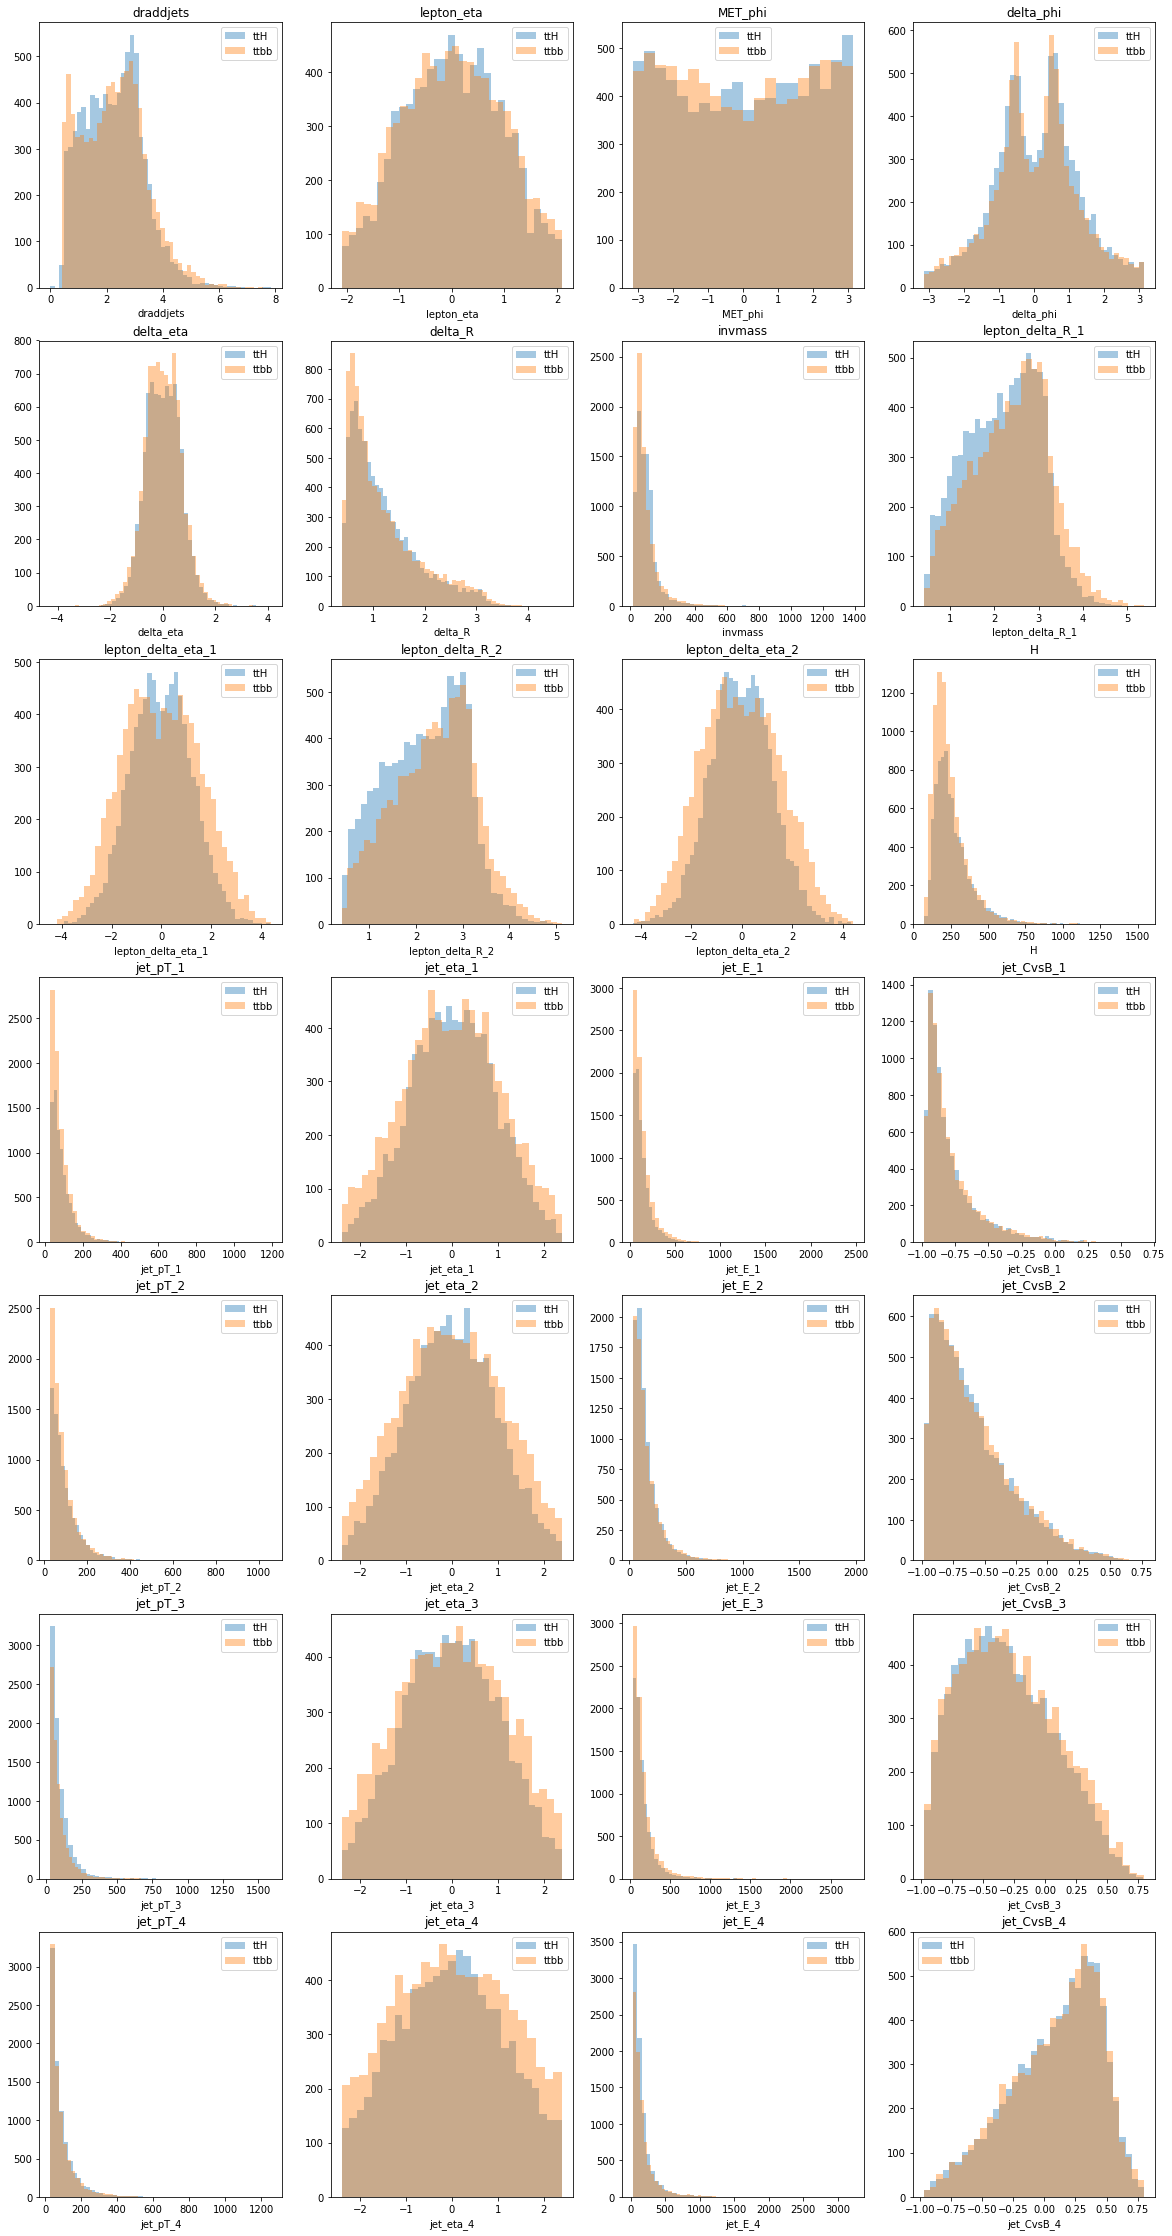

In [13]:
#Visualization of all features within the ttBHH set compared to the TTLJ
fig = plt.figure(figsize=(20,40))
axes = fig.subplots(nrows=7, ncols=4)
col = train_tree.columns
c_num = 0

for ax in axes:
    for row in ax:
        sns.distplot(train_tree[col[c_num]], ax=row, kde = False, label="ttH")
        sns.distplot(train_tree_2[col[c_num]], ax=row, kde = False, label="ttbb")
        row.set_title(col[c_num])
        row.legend()
        c_num += 1
        if c_num > len(col) - 1:
            break
#plt.show()
fig.savefig('variable_distribution.png')

### 2.2 RFE Feature Selection

In [9]:
ranks = {}
colnames = full_train.columns
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [10]:
#Using RFE
estimator = LinearRegression(normalize=True)
selector = RFE(estimator, n_features_to_select = 1, verbose = 3)
selector = selector.fit(train, y_pred)
ranks["RFE"] = ranking(list(map(float, selector.ranking_)), colnames, order=-1)

Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [11]:
#Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(train, y_pred)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

#Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(train, y_pred)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

In [12]:
#Using Random Forest
rf = RandomForestClassifier(n_estimators=100, max_features=15, max_depth=11, random_state=1)
rf.fit(train, y_pred)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

In [13]:
#Present the final result as the mean of four model weights combined
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

**Feature Selection Insights**

Lasso: Pick out top performing features and force the rest to be zero

RF: Sharp drop-off score after first few top ones

Ridge: Forces regression score to spread out similarly between correlated variables

RFE: Compromise between data interpretation and top feature selection for model improvement

In [14]:
print "\t\t", "\t".join(methods)
for name in colnames:
    nameit = name
    if len(name) == 3:
        nameit += "\t"
    print nameit, "\t","\t".join(map(str,[ranks[method][name] for method in methods]))

		Lasso	RF	RFE	Ridge	Mean
draddjets 	0.0	0.36	0.37	0.05	0.2
lepton_eta 	0.0	0.06	0.07	0.01	0.04
MET_phi 	0.0	0.06	0.19	0.02	0.07
delta_phi 	0.0	0.02	0.04	0.01	0.02
delta_eta 	0.0	0.07	0.93	0.0	0.25
delta_R 	0.0	0.17	0.44	0.08	0.17
invmass 	0.0	1.0	0.48	0.17	0.41
lepton_delta_R_1 	0.0	0.27	0.59	0.32	0.3
lepton_delta_eta_1 	0.0	0.62	0.96	0.03	0.4
lepton_delta_R_2 	0.0	0.11	0.56	0.3	0.24
lepton_delta_eta_2 	0.0	0.78	1.0	0.02	0.45
H 	0.0	0.11	0.67	0.88	0.42
jet_pT_1 	0.0	0.15	0.89	0.9	0.48
jet_eta_1 	0.0	0.18	0.33	0.08	0.15
jet_E_1 	0.0	0.04	0.85	1.0	0.47
jet_CvsB_1 	0.0	0.08	0.3	0.04	0.1
jet_pT_2 	0.0	0.08	0.74	0.7	0.38
jet_eta_2 	0.0	0.14	0.11	0.01	0.07
jet_E_2 	0.0	0.11	0.7	0.97	0.45
jet_CvsB_2 	0.0	0.0	0.26	0.03	0.07
jet_pT_3 	0.0	0.04	0.78	0.53	0.34
jet_eta_3 	0.0	0.17	0.15	0.02	0.08
jet_E_3 	0.0	0.11	0.81	0.98	0.48
jet_CvsB_3 	0.0	0.08	0.41	0.1	0.15
jet_pT_4 	0.0	0.02	0.52	0.13	0.17
jet_eta_4 	0.0	0.16	0.22	0.03	0.1
jet_E_4 	0.0	0.13	0.63	0.69	0.36
jet_CvsB_4 	0.0	0.04	0.0	0.0	0.01


In [15]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

/home/9304220184/python27/local/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


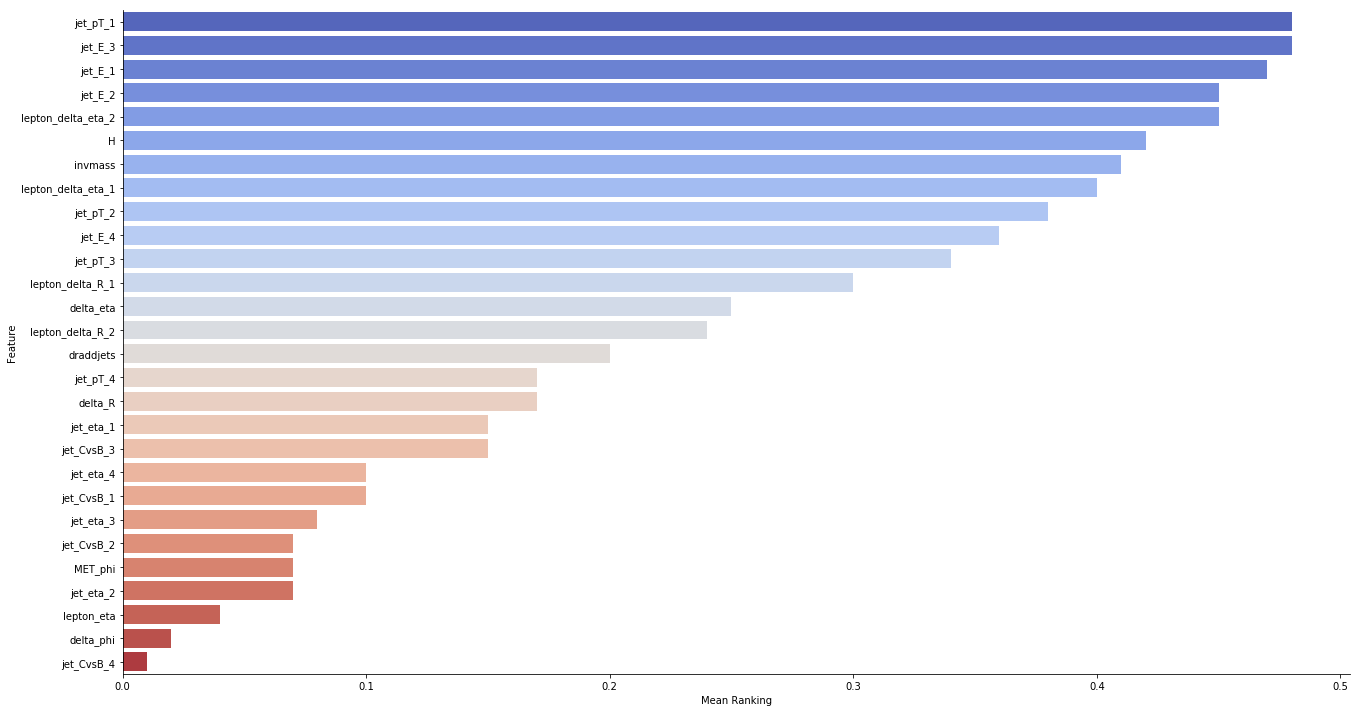

In [16]:
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", height=10, aspect=1.9, palette='coolwarm')

### 2.3 Train-Validation-Test Set Split

In [8]:
X_train, X_temp, Y_train, Y_temp = train_test_split(train, y_pred, test_size = 0.4, random_state = 42)

In [9]:
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.4, random_state = 42)

In [10]:
#Transform one dimensional data to two dimensions
Y_train_nn = np_utils.to_categorical(Y_train)
Y_valid_nn = np_utils.to_categorical(Y_valid)

In [11]:
Y_train = np.array(Y_train)
Y_valid = np.array(Y_valid)
Y_test = np.array(Y_test)

# 3. Neural Networks

### 3.1 Hyperparameter Tuning

In [18]:
import talos as ta
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from talos.model.layers import hidden_layers
from talos.model.normalizers import lr_normalizer
import tensorflow as tf

In [19]:
final_scan = ta.Restore('higgs_nn.zip')

2018-11-30 11:25:54.504732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-11-30 11:25:54.504888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-11-30 11:25:54.504906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-11-30 11:25:54.504917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-11-30 11:25:54.505832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 3656 MB memory) -> physical GPU (device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1)


In [20]:
final_scan.params

{'activation': [<function keras.activations.relu>],
 'batch_size': [32, 64, 128],
 'dropout': (0, 0.5, 1.5),
 'emb_output_dims': [None],
 'epochs': [70],
 'first_neuron': [16, 32],
 'hidden_layers': [6, 8, 10],
 'last_activation': [<function keras.activations.sigmoid>],
 'losses': [<function keras.losses.categorical_crossentropy>],
 'lr': [0.01],
 'optimizer': [keras.optimizers.SGD, keras.optimizers.RMSprop],
 'shape': ['brick', 'long_funnel'],
 'weight_regulizer': [None]}

In [21]:
final_scan.details

,0,1
0,complete_time,11/29/18/00:49
1,experiment_name,higgs_nn_1
2,grid_downsample,NaN
3,random_method,uniform_mersenne
4,reduce_loss,False
5,reduction_interval,50
6,reduction_method,NaN
7,reduction_metric,val_acc
8,reduction_threshold,0.2
9,reduction_window,20


In [26]:
talo_re = final_scan.model.predict(X_valid)
talo_re = np.array([i[1] for i in talo_re])

In [27]:
print "Accuracy score for Neural Network is: ", accuracy_score(Y_valid, talo_re.round())
print "Precision score for Neural Network is: ", precision_score(Y_valid, talo_re.round())
print "Recall score for Neural Network is: ", recall_score(Y_valid, talo_re.round())
print "F1 score for Neural Network is: ", f1_score(Y_valid, talo_re.round())

Accuracy score for Neural Network is:  0.5003650523241665
Precision score for Neural Network is:  0.5003650523241665
Recall score for Neural Network is:  1.0
F1 score for Neural Network is:  0.6669910786699108


_Hyperparameter tuning execution code is commented out to save time_

In [18]:
#Define the model to train on
def higgs_nn(X_train, Y_train, X_valid, Y_valid, params):
    model = Sequential()
    model.add(Dense(75, input_dim=X_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer='normal'))
    model.add(Dropout(params['dropout']))

    hidden_layers(model, params, 1)
    
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=['acc'])
    
    history = model.fit(X_train, Y_train, 
                        validation_data=[X_valid, Y_valid],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    # finally we have to make sure that history object and model are returned
    return history, model  

In [19]:
#Define hyperparameters that need to be tuned
# p = {'lr': (0.5, 5, 10),
#      'first_neuron':[4, 8, 16, 32, 64],
#      'hidden_layers':[2, 3, 4, 5, 6],
#      'batch_size': (2, 10, 30),
#      'epochs': [70],
#      'dropout': (0, 0.5, 5),
#      'weight_regulizer':[None],
#      'emb_output_dims': [None],
#      'shape':['brick','long_funnel'],
#      'optimizer': [Adam, Nadam, RMSprop],
#      'losses': [logcosh, binary_crossentropy],
#      'activation':[relu, elu],
#      'last_activation': [sigmoid]}

In [20]:
# h = ta.Scan(train, np.array(y_pred.tolist()), params=p,
#             model=higgs_nn,
#             dataset_name='higgs_nn',
#             experiment_no='1',
#             grid_downsample=0.1)

### 3.2 Model Implementation

In [35]:
model = Sequential()
model.add(Dropout(0.13, input_shape=(X_train.shape[1],)))
model.add(Dense(300))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(200))
model.add(PReLU())

model.add(Dropout(0.09))
model.add(Dense(100))
model.add(PReLU())

model.add(Dropout(0.07))
model.add(Dense(50))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(15))
model.add(PReLU())

model.add(Dense(2))
model.add(Activation('sigmoid'))

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.1, nesterov=True), metrics=['accuracy'])

In [37]:
model.fit(X_train, Y_train_nn, batch_size=128, epochs=70, verbose=2, shuffle=True, validation_data = (X_valid, Y_valid_nn))

Train on 10273 samples, validate on 4109 samples
Epoch 1/70
 - 1s - loss: 0.6935 - acc: 0.4972 - val_loss: 0.6928 - val_acc: 0.5142
Epoch 2/70
 - 1s - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6925 - val_acc: 0.5232
Epoch 3/70
 - 1s - loss: 0.6928 - acc: 0.5151 - val_loss: 0.6923 - val_acc: 0.5111
Epoch 4/70
 - 1s - loss: 0.6923 - acc: 0.5198 - val_loss: 0.6915 - val_acc: 0.5456
Epoch 5/70
 - 1s - loss: 0.6917 - acc: 0.5278 - val_loss: 0.6907 - val_acc: 0.5349
Epoch 6/70
 - 1s - loss: 0.6916 - acc: 0.5278 - val_loss: 0.6901 - val_acc: 0.5337
Epoch 7/70
 - 1s - loss: 0.6904 - acc: 0.5375 - val_loss: 0.6891 - val_acc: 0.5430
Epoch 8/70
 - 1s - loss: 0.6888 - acc: 0.5403 - val_loss: 0.6884 - val_acc: 0.5298
Epoch 9/70
 - 1s - loss: 0.6880 - acc: 0.5398 - val_loss: 0.6879 - val_acc: 0.5534
Epoch 10/70
 - 1s - loss: 0.6877 - acc: 0.5366 - val_loss: 0.6866 - val_acc: 0.5590
Epoch 11/70
 - 1s - loss: 0.6873 - acc: 0.5423 - val_loss: 0.6844 - val_acc: 0.5505
Epoch 12/70
 - 1s - loss: 0.6869 - a

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               8700      
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 300)               300       
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               60200     
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 200)               200       
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
__________

In [21]:
nn_test = model.predict(X_valid)
nn_test = np.array([float(i[1])/(i[0] + i[1]) for i in nn_test])
print "Accuracy score for Neural Network is: ", accuracy_score(Y_valid, nn_test.round())
print "Precision score for Neural Network is: ", precision_score(Y_valid, nn_test.round())
print "Recall score for Neural Network is: ", recall_score(Y_valid, nn_test.round())
print "F1 score for Neural Network is: ", f1_score(Y_valid, nn_test.round())

Accuracy score for Neural Network is:  0.6093940131418837
Precision score for Neural Network is:  0.5738617753029807
Recall score for Neural Network is:  0.8521400778210116
F1 score for Neural Network is:  0.6858485026423958


# 4. Gradient Boosting

In [22]:
xgb = XGBRegressor()

In [23]:
params={
    'objective': ['binary:logistic'],
    'learning_rate': [0.1],
    'max_depth': [3],
    'gamma': [0.4],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': [200],
}

_The code commented out here is to use GridSearchCV to find best parameters_

In [24]:
# grs = GridSearchCV(xgb, param_grid=params, cv=2, n_jobs=4, verbose=2)
# grs.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=False)

# grs.cv_results_, grs.best_params_

In [25]:
my_model = XGBRegressor(
    objective = 'binary:logistic',
    learning_rate = 0.01,
    max_depth = 4,
    gamma = 0.4,
    min_child_weight = 1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    n_estimators = 1000,
    silent = 1
)

In [26]:
my_model.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.8)

In [27]:
gb_test = my_model.predict(X_valid)

In [28]:
Y_valid = np.array(Y_valid)

In [29]:
print "Accuracy score for Gradient Boosting is: ", accuracy_score(Y_valid, gb_test.round())
print "Precision score for Gradient Boosting is: ", precision_score(Y_valid, gb_test.round())
print "Recall score for Gradient Boosting is: ", recall_score(Y_valid, gb_test.round())
print "F1 score for Gradient Boosting is: ", f1_score(Y_valid, gb_test.round())

Accuracy score for Gradient Boosting is:  0.6291068386468727
Precision score for Gradient Boosting is:  0.6269083969465649
Recall score for Gradient Boosting is:  0.6391050583657587
F1 score for Gradient Boosting is:  0.6329479768786127


# 5. Random Forest

In [30]:
rf = RandomForestClassifier(n_estimators=100, max_features=15, max_depth=12, random_state=1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [31]:
rf_test = rf.predict(X_valid)
Y_valid = np.array(Y_valid)

In [32]:
print "Accuracy score for Random Forest is: ", accuracy_score(Y_valid, rf_test.round())
print "Precision score for Random Forest is: ", precision_score(Y_valid, rf_test.round())
print "Recall score for Random Forest is: ", recall_score(Y_valid, rf_test.round())
print "F1 score for Random Forest is: ", f1_score(Y_valid, rf_test.round())

Accuracy score for Random Forest is:  0.6203455828668776
Precision score for Random Forest is:  0.6159962581852199
Recall score for Random Forest is:  0.6405642023346303
F1 score for Random Forest is:  0.6280400572246065


# 6. Ensemble Learning

The following implementation using the "stacking" technique of ensemble learning. For more info, please check this [**ref**](https://blog.statsbot.co/ensemble-learning-d1dcd548e936)

In [33]:
Y_test = np.array(Y_test)

In [34]:
nn_test = model.predict(X_test)
gb_test = my_model.predict(X_test)
rf_test = rf.predict(X_test)
ta_test = final_scan.model.predict(X_test)

NameError: name 'final_scan' is not defined

In [ ]:
nn_test = np.array([float(i[1])/(i[0] + i[1]) for i in nn_test])
ta_test = np.array([i[0] for i in ta_test])

In [ ]:
#The overall score is given by a combination of three models (NN, RF, GB)
print "Accuracy score for combined model is: ", accuracy_score(Y_test, (nn_test*0.6 + gb_test*0.3 + rf_test*0.1).round())
print "Precision score for combined model is: ", precision_score(Y_test, (nn_test*0.6 + gb_test*0.3 + rf_test*0.1).round())
print "Recall score for combined model is: ", recall_score(Y_test, (nn_test*0.6 + gb_test*0.3 + rf_test*0.1).round())
print "F1 score for combined model is: ", f1_score(Y_test, (nn_test*0.6 + gb_test*0.3 + rf_test*0.1).round())

# 7. ROC Curve

In [ ]:
y_prob = nn_test*0.6 + gb_test*0.3 + rf_test*0.1

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# 8. Predicted Probability Density Function (PDF)

In [ ]:
signals = []
backgrounds = []

for i in range(len(Y_test)):
    if Y_test[i] == 0:
        backgrounds.append(y_prob[i])
    else:
        signals.append(y_prob[i])

In [ ]:
sns.distplot(signals,label="Signal",kde = False)
sns.distplot(backgrounds,label="Background", kde = False)
plt.legend()
plt.xlabel("Predicted probability of 1")
plt.ylabel("Number of occurences")
plt.show()

_Confusion Matrix_

In [ ]:
pd.DataFrame(confusion_matrix(Y_test, [i.round() for i in y_prob]))